여러분은 왜 개 사료가 예상보다 빨리 상하게 되는지를 파악하기위해 개 사료 회사에 고용되었습니다. 안 좋은 소식은 이 회사는 한동안 장비를 업그레이드 하지 않았습니다. 즉, 이 회사에서 사용하는 5가지 방부제의 사용 용량이 중구난방이라는 뜻입니다. 하지만 그 중에서 가장 많은 영향을 끼치는 것이 무엇일까요?<br>
이 회사에서는 먼저 4가지 방부제(A, B, C, D)가 함유된 방부제 묶음을 섞은 뒤 '필러'라는 화학물질로 마무리합니다. 식품과학자들은 A, B, C, D 방부제 중 하나가 문제를 일으키고 있다고 생각하지만, 그게 어떤 것인지 명확하게 하기위해 여러분이 고용됐습니다. "랜덤포레스트"로 어떤 방부제가 사료를 빨리 상하게 하는지 찾아보세요!

- Pres_A : 혼합물의 A비율
- Pres_B : 혼합물의 B비율
- Pres_C : 혼합물의 C비율
- Pres_D : 혼합물의 D비율
- Spoiled : 개 사료가 상했는지 여부를 나타내는 레이블.

**시나리오에서 요구하는 바를 고려하여, 머신러닝을 이용해서 문제를 풀어보세요.**

In [54]:
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler

from scipy.special import expit, softmax
import statsmodels.api as sm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import myfx as m

In [3]:
df = pd.read_csv("./data/dog_food.csv")

In [4]:
df.head()

,A,B,C,D,Spoiled
0,4,2,12.0,3,1.0
1,5,6,12.0,7,1.0
2,6,2,13.0,6,1.0
3,4,2,12.0,1,1.0
4,4,2,12.0,3,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   A        490 non-null    int64  
 1   B        490 non-null    int64  
 2   C        490 non-null    float64
 3   D        490 non-null    int64  
 4   Spoiled  490 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 19.3 KB


- 결측값 없음

In [6]:
df.describe()

,A,B,C,D,Spoiled
count,490.000000,490.000000,490.000000,490.000000,490.000000
mean,5.534694,5.504082,9.126531,5.579592,0.285714
std,2.951520,2.853797,2.055545,2.854837,0.452216
min,1.000000,1.000000,5.000000,1.000000,0.000000
25%,3.000000,3.000000,8.000000,3.000000,0.000000
50%,5.000000,6.000000,9.000000,6.000000,0.000000
75%,8.000000,8.000000,11.000000,8.000000,1.000000
max,10.000000,10.000000,14.000000,10.000000,1.000000


- 모든 방부제에 이상치는 없는것으로 보이고, 방부제 C의 비중이 다른 방부제에 비해 큰값이므로 스케일링이 필요해보임

<Axes: >

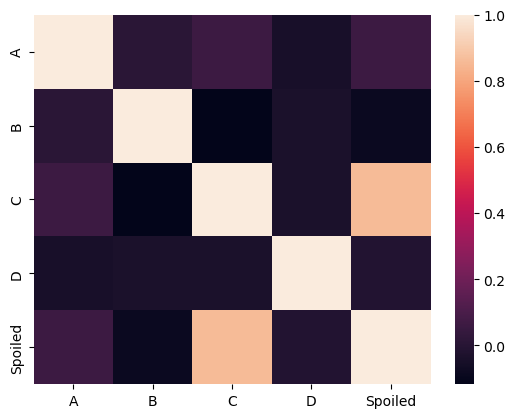

In [7]:
df_corr = df.corr()
sns.heatmap(df_corr, fmt=".2f")

In [8]:
df["Spoiled"].value_counts()

Spoiled
0.0    350
1.0    140
Name: count, dtype: int64

(0.0, 15.0)

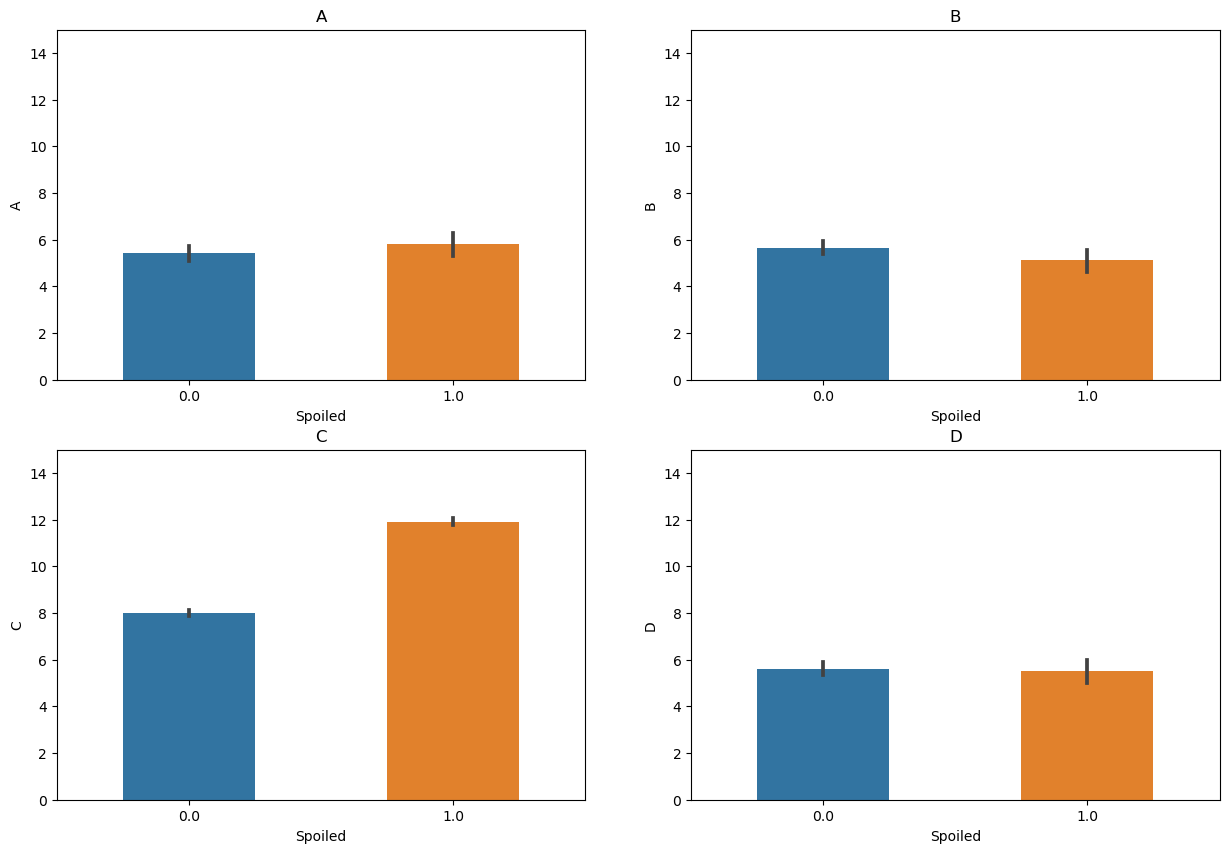

In [9]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
sns.barplot(data=df, x="Spoiled", y="A", ax=ax1, width=0.5)
sns.barplot(data=df, x="Spoiled", y="B", ax=ax2, width=0.5)
sns.barplot(data=df, x="Spoiled", y="C", ax=ax3, width=0.5)
sns.barplot(data=df, x="Spoiled", y="D", ax=ax4, width=0.5)

ax1.set_title("A")
ax2.set_title("B")
ax3.set_title("C")
ax4.set_title("D")

ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)
ax4.set_ylim(0, 15)

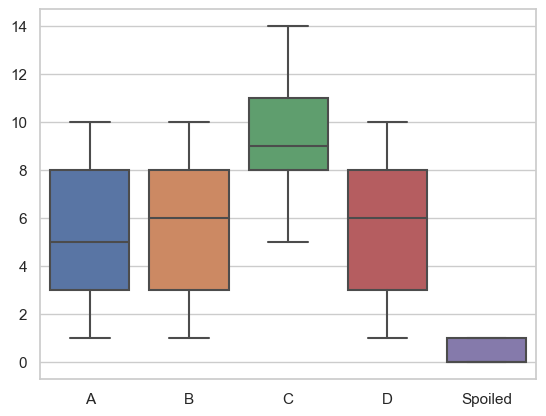

In [40]:
sns.set_theme(style="whitegrid")

plt.figure()
sns.boxplot(df)
plt.show()

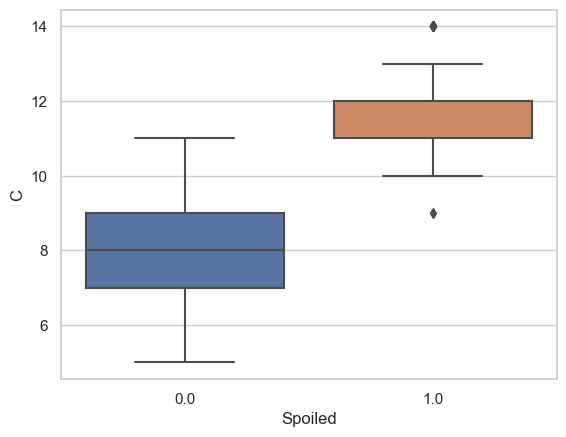

In [48]:
plt.figure()
sns.boxplot(x="Spoiled", y="C", data=df)
plt.show()

- 상하게 하는 원인중 C의 영향이 가장 클것으로 보임

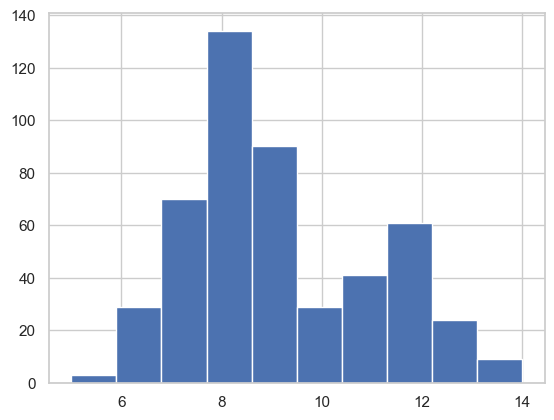

In [41]:
# C의 히스토그램
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
plt.hist(df["C"])
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


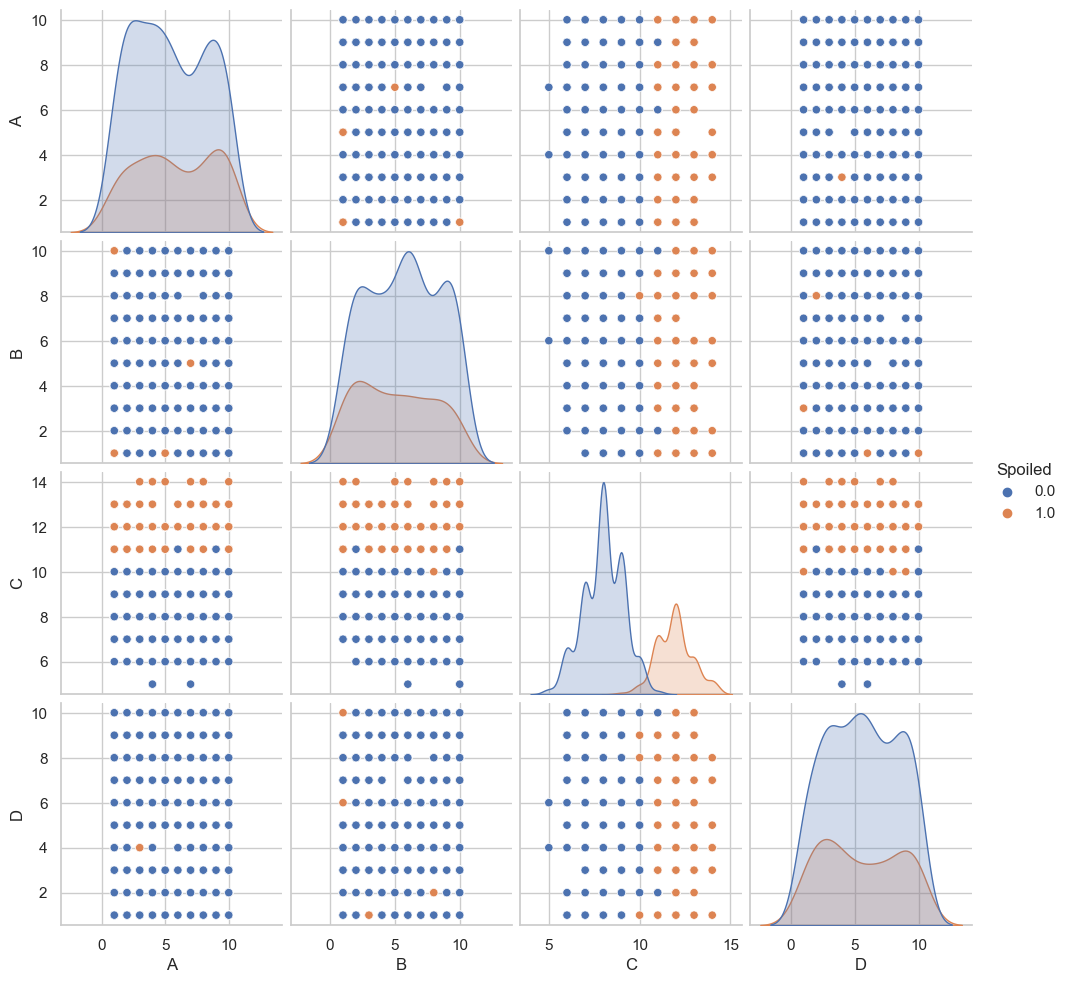

In [42]:
sns.pairplot(df, hue="Spoiled")
plt.show()

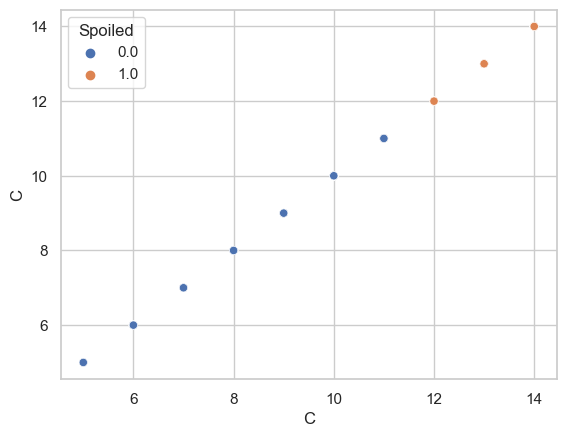

In [43]:
sns.scatterplot(data=df, x="C", y="C", hue="Spoiled")
plt.show()

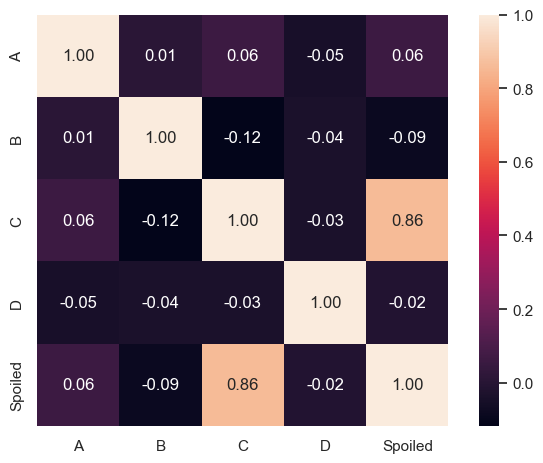

In [45]:
plt.figure()

hm = sns.heatmap(
    df_corr.values,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    yticklabels=df.columns,
    xticklabels=df.columns,
)
plt.tight_layout()
plt.show()

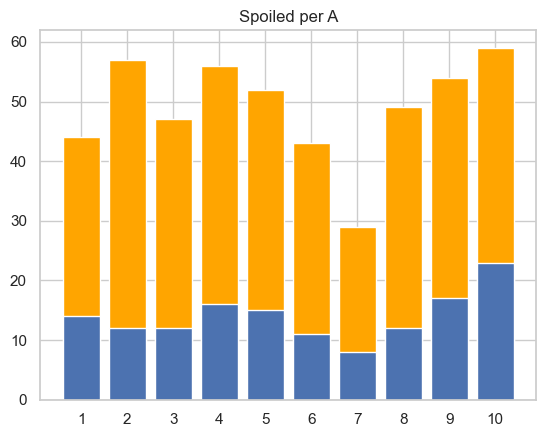

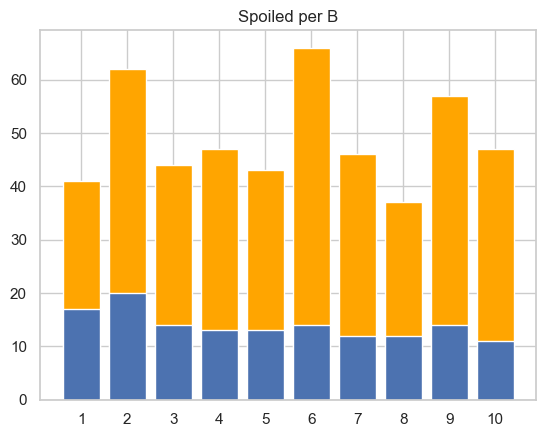

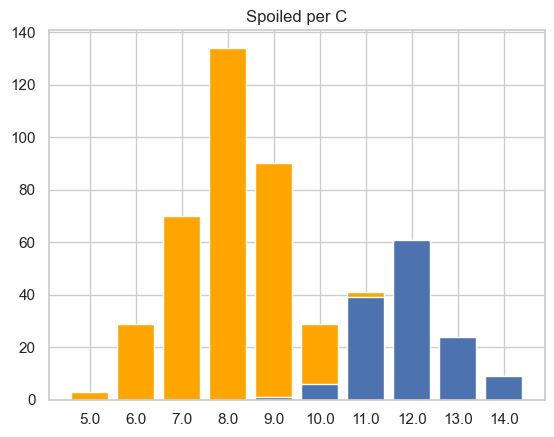

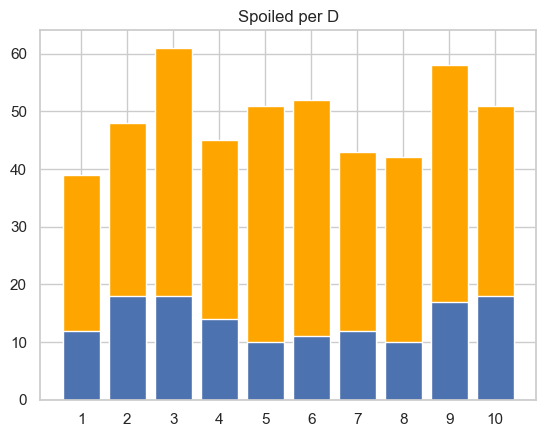

In [47]:
for i in df.columns[:-1]:
    plt.bar(
        np.arange(len(df[i].sort_values().unique())),
        df[i].value_counts().sort_index(),
        color="orange",
    )
    plt.bar(
        np.arange(len(df[i].sort_values().unique())),
        df.groupby(i)["Spoiled"].sum().values,
    )
    plt.xticks(
        np.arange(len(df[i].sort_values().unique())), df[i].sort_values().unique()
    )
    plt.title(f"Spoiled per {i}")
    plt.show()

# 통계 분석

In [55]:
# 분산의 동일성 검정
stats.bartlett(df.loc[df["Spoiled"] == 1, "C"], df.loc[df["Spoiled"] == 0, "C"])

BartlettResult(statistic=2.433612464987829, pvalue=0.11875893707242617)

In [57]:
# t-test
# 두 집단의 평균이 다르다
stats.ttest_ind(
    df.loc[df["Spoiled"] == 1, "C"], df.loc[df["Spoiled"] == 0, "C"], equal_var=True
)

TtestResult(statistic=37.00175815922425, pvalue=1.0006887690101255e-143, df=488.0)

In [10]:
# Spoiled열을 종속변수로 지정
x, y = m.dataset_split(df, "Spoiled")

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=3056)

In [12]:
ss = StandardScaler()

In [13]:
ss_train = ss.fit_transform(x_train)
ss_test = ss.transform(x_test)

In [14]:
rf = RandomForestClassifier(n_jobs=-1, random_state=3056)

# 랜덤포레스트

In [15]:
rf.fit(ss_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=3056)

In [16]:
rf.feature_importances_

array([0.02793877, 0.02901146, 0.91381764, 0.02923213])

In [17]:
rf.score(ss_test, y_test)

0.967479674796748

1. 세 모델 모두 상하게 하는 물질 중 혼합물의 C 비율에 큰 비중을 차지하고 있다.
- 평가 : 0.9674

# 엑스트라 트리

In [18]:
et = ExtraTreesClassifier(n_jobs=-1, random_state=3056)

In [19]:
et.fit(ss_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=3056)

In [20]:
et.feature_importances_

array([0.0340486 , 0.03377137, 0.88824006, 0.04393997])

In [21]:
et.score(ss_test, y_test)

0.967479674796748

2. 가장 큰 비중을 차지하는 혼합물은 C

# 그레디언트 부스팅

In [22]:
gb = GradientBoostingClassifier(random_state=3056)

In [23]:
gb = GradientBoostingClassifier(random_state=11, n_estimators=500, learning_rate=0.2)
scores = cross_validate(gb, x_train, y_train, return_train_score=True, n_jobs=-1)

In [24]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.9959137238513153 0.9754535357275083


In [25]:
gb.fit(ss_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=500, random_state=11)

In [26]:
gb.feature_importances_

array([0.00246584, 0.00586815, 0.9705874 , 0.02107862])

3. 혼합물 c의 비중이 가장 크다

# 로지스틱 회귀

- Spoiled 값을 예측할 때 결정되는 확률값을 이용하여 어떤 혼합물의 비중이 큰지 확인

In [27]:
logi = LogisticRegression()
logi.fit(ss_train, y_train)

LogisticRegression()

In [28]:
logi.score(ss_test, y_test)

0.967479674796748

In [29]:
logi.coef_, logi.intercept_

(array([[ 0.06466989,  0.06142512,  4.77760909, -0.0560387 ]]),
 array([-2.93607504]))

z = (A * 0.06) + (B * 0.06) + (C * 4.78) - (D * 0.06) -2.94

4. 회귀식의 계수중 C의 계수가 가장크다
- 로지스틱 회귀 평가 : 0.9674

# 선형회귀

In [30]:
lr = LinearRegression()

In [31]:
lr.fit(ss_train, y_train)

LinearRegression()

In [32]:
lr.score(ss_test, y_test)

0.6892631450075198

- 정확도가 낮으므로 선형회귀는 보류


# 확률적 경사하강법

In [33]:
sgd = SGDClassifier(loss="hinge", max_iter=10, random_state=3056)

In [34]:
sgd.fit(ss_train, y_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=10, random_state=3056)

In [35]:
print(sgd.score(ss_train, y_train))
print(sgd.score(ss_test, y_test))

0.9754768392370572
0.959349593495935


In [36]:
sgd.coef_

array([[-4.80987047,  0.2619938 , 30.76785964, -2.7970834 ]])

5. 가중치가 C가 가장 높다.
- 확률적 경사사강법 평가 : 0.9593

In [37]:
import myfx as m